## Downsampled datas tensor - same workflow for TDA

- PCA->UMAP embedding
- CEBRA embedding
- Ripser and barcodes
- Bottleneck and wasserstein distances

Author: @emilyekstrum
<br> 11/17/25

In [1]:
import cebra
import itertools
import os
import torch
import matplotlib
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from torch import cdist

from cebra import CEBRA
from cebra.data.helper import OrthogonalProcrustesAlignment
from glob import glob
from pathlib import Path
from dlab.psth_and_raster import trial_by_trial
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from umap import UMAP
from ripser import ripser
import gudhi as gd
from gudhi import representations
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from persim import PersImage, PersistenceImager, plot_diagrams, bottleneck, bottleneck_matching, wasserstein, PersLandscapeExact
from persim.landscapes import plot_landscape_simple, plot_landscape
from sklearn.manifold import Isomap

plt.style.use(['default', 'seaborn-v0_8-paper'])

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

c:\Users\denmanlab\.conda\envs\topology\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [7]:
# load in data
units_dir = r'Z:\color_representation\units'
stim_dir  = r'Z:\color_representation\stim'

downsample_factor = 0.5

recordings = ['d4','d5','d6','C153','C155','C159','C160','C161']
#recordings = ["C153"]

stim="drifting_gratings"

bin_     = 0.010
pre      = 0.500
post     = 1.500
window   = pre+post
n_bins   = int(window/bin_)

datas      = []
all_probes = []
all_ids    = []

for m,mouse in enumerate(recordings):
    print(f'Mouse {mouse}')

    #Load in stimulus dataframe
    stim_df  = pd.read_json(glob(os.path.join(stim_dir,f'{mouse}*updated*'))[0])
    
    #Check for stimulus before loading in more data
    if stim not in stim_df.stimulus.unique():
        print(f'No {stim}')
        continue

    stim_df = stim_df.loc[stim_df.stimulus == stim]
    
    print('Loading Data....')
    #Load in unit data
    units_df    = pd.read_json(glob(os.path.join(units_dir,f'{mouse}*'))[0])
    units_good  = units_df.loc[(units_df.qmLabel == 'GOOD')|(units_df.qmLabel == 'NON-SOMA GOOD')]
    #units_good  = units_good.loc[(units_good.region.str.contains('Primary visual'))|(units_good.region.str.contains('lateral geniculate'))]
    units_good  = units_good.loc[(units_good.region.str.contains('lateral geniculate'))]
    units_good.reset_index(inplace=True,drop=True)
    units_df    = None

    if len(units_good) < 1:
        continue        

    # Stim timing
    stim_times_full = stim_df.loc[:, 'start_time'].values

    #Wrangle stimulus-relevant data
    stim_df     = stim_df.loc[(stim_df.stimulus == stim)]
    stim_times  = stim_df.loc[:,'start_time'].values
    stim_length = stim_times[-1]-stim_times[0]
    
    #Organize spike data (y)
    n_trials = len(stim_times)
    n_units  = len(units_good)
    
    yall = np.zeros((n_trials,n_bins,n_units))

    probes = []
    cIDs   = []
    rec_data = []
    k = 0
    for i,row in units_good.iterrows():
        spike_times = np.array(row.times)
        stim_spikes = spike_times[(spike_times > stim_times[0]) & (spike_times < stim_times[-1]+post)]
        
        if len(stim_spikes)/stim_length < 0.5:
            continue

        psth, var, edges, bytrial = trial_by_trial(stim_spikes, stim_times, pre, post, bin_)
        # bytrial: shape (n_trials, n_bins)

     # spike count per trial - below is removes time
        trial_vec = bytrial.sum(axis=1)                 # shape (n_trials,)

        rec_data.append(trial_vec)

        X_trial_neuron = np.column_stack(rec_data).astype(np.float32)  # (n_trials, n_units)

        num_neurons = X_trial_neuron.shape[1] * downsample_factor
        # X_trial_neuron: shape (n_trials, n_units)
        #X_trial_neuron, kept_idx = randomly_select_neurons(X_trial_neuron, num_neurons=100)

    datas.append(torch.from_numpy(X_trial_neuron))
    print(torch.from_numpy(X_trial_neuron).shape)



Mouse d4
No drifting_gratings
Mouse d5
Loading Data....
torch.Size([640, 92])
Mouse d6
Loading Data....
torch.Size([640, 91])
Mouse C153
Loading Data....
torch.Size([160, 133])
Mouse C155
Loading Data....
torch.Size([320, 16])
Mouse C159
Loading Data....
torch.Size([320, 160])
Mouse C160
Loading Data....
torch.Size([320, 51])
Mouse C161
Loading Data....
torch.Size([320, 94])


In [20]:
to_save = {
    'datas': datas,
    'recordings': recordings
}

with open('C:/Users/denmanlab/Desktop/Emily_rotation/data_to_run_at_home/LGN_d5_downsamp_no_time.pkl', 'wb') as f:
    pkl.dump(to_save, f)

Using 60 PCA components to retain 90% variance.
Running UMAP on C153
C153


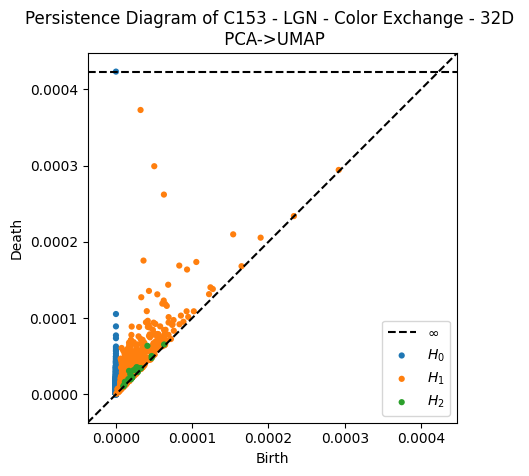

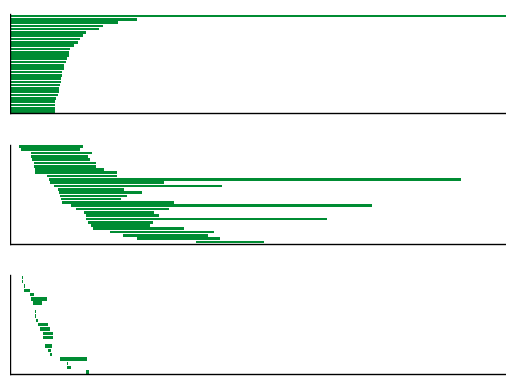

In [14]:
# pca umap
def pca_umap(recordings, datas, n_pca_components=10, n_umap_components=3, n_neighbors=600, min_dist=0.8, metric='cosine', save=True):
    """
    Perform PCA followed by UMAP
    """
    single_session_pca_umap = {}
    pca_umap_embeddings = {}

    for name, X in zip(recordings, datas):

        #zscore
        X_scaled = StandardScaler().fit_transform(X)

        #PCA - retain 90% variance
        pca_full = PCA(svd_solver='auto', random_state=42).fit(X_scaled)
        sum_var = np.cumsum(pca_full.explained_variance_ratio_)
        k = max(32, np.searchsorted(sum_var, 0.9)+1)
        k_safe = min(k, min(X_scaled.shape))  # Ensure k does not exceed min(n_samples, n_features)
        print(f"Using {k_safe} PCA components to retain 90% variance.")

        pca = PCA(n_components=k_safe, svd_solver='auto', random_state=42)
        X_pca = pca.fit_transform(X_scaled)

        print(f"Running UMAP on {name}")
        umap = UMAP(n_components=n_umap_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, n_jobs=-1)
        Z = umap.fit_transform(X_pca)

        pca_umap_embeddings[name] = Z
        single_session_pca_umap[name] = {'model' : umap, "embedding" : Z, "tensor" : X}

    #if save == True:
        #save_embedding_to_pkl(single_session_pca_umap, f'{filepath}{filename}.pkl')

    return single_session_pca_umap, pca_umap_embeddings

single_session, pca_umap_embeddings = pca_umap(recordings, datas, n_pca_components=10, n_umap_components=3, n_neighbors=600, min_dist=0.8, metric='cosine', save=False)

for n, name in enumerate(recordings):
    embedding = single_session[name]['embedding']
    sparse_matrix = knn_sparse_dist(embedding, n_neighbors=300, metric='cosine')
    print(f"{name}")
    dgms = tda_ripser(sparse_matrix, name, "LGN - Color Exchange - 32D \n PCA->UMAP", maxdim=2)
    plot_barcode(dgms)
    #persistence_diagrams[name] = dgms

In [12]:
# train CEBRA model
test_recordings = ['C153', 'C159']
single_session_CEBRA = CEBRA_model_train(test_recordings, datas, model_architecture='offset10-model', device='cuda', output_dimension=3, 
                     train_steps=30000, distance='cosine', filepath='/Users/emilyekstrum/Desktop/denmanLab/tda/actual_work/', filename='cebra_lgn_gratings', save=False)
#save_embedding_to_pkl(single_session_CEBRA, f'/Users/emilyekstrum/Desktop/denmanLab/tda/actual_work/cebra_lgn_gratings.pkl')
#plot_3d_CEBRA()

C153


pos: -0.9992 neg:  6.3993 total:  5.4001 temperature:  1.0000: 100%|██████████| 30000/30000 [02:48<00:00, 177.75it/s]


C159


pos: -0.9994 neg:  6.3997 total:  5.4003 temperature:  1.0000: 100%|██████████| 30000/30000 [02:50<00:00, 175.77it/s]


In [15]:
save_embedding_to_pkl(single_session_CEBRA, f'C:/Users/denmanlab/Desktop/Emily_rotation/downsamp_test.pkl')


Saved embeddings to C:/Users/denmanlab/Desktop/Emily_rotation/downsamp_test.pkl


C153


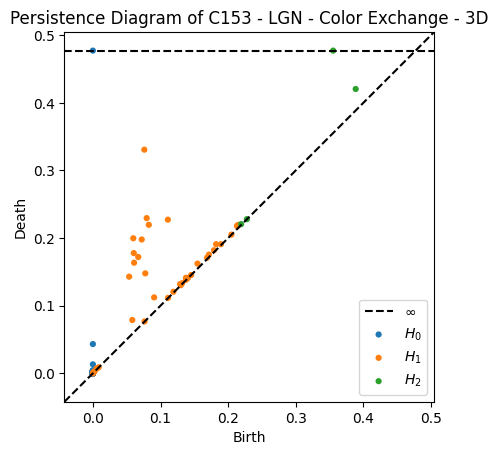

C159


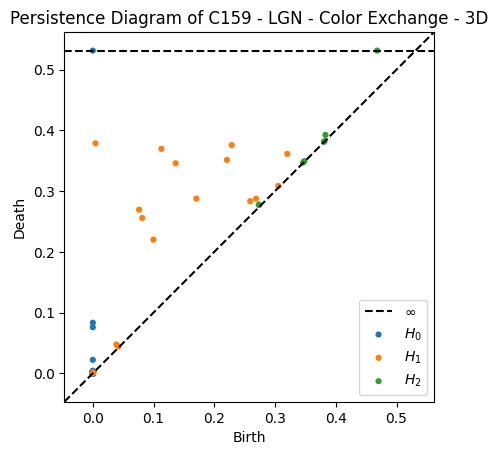

In [ ]:
# persistence diagrams
persistence_diagrams = {}
single_session = pd.read_pickle(r'C:/Users/denmanlab/Desktop/Emily_rotation/downsamp_test.pkl')
good_recordings = ['C153', 'C159']


for n, name in enumerate(good_recordings):
    embedding = single_session[name]['embedding']
    sparse_matrix = knn_sparse_dist(embedding, n_neighbors=300, metric='cosine')
    print(f"{name}")
    dgms = tda_ripser(sparse_matrix, name, "LGN - Color Exchange - 3D", maxdim=2)
    persistence_diagrams[name] = dgms

In [32]:
for key, val in persistence_diagrams.items():
    for i, dgm in enumerate(val):
        print(f"{key} | H{i} | shape: {dgm.shape}")

C153 | H0 | shape: (680, 2)
C153 | H1 | shape: (41, 2)
C153 | H2 | shape: (4, 2)
C159 | H0 | shape: (680, 2)
C159 | H1 | shape: (20, 2)
C159 | H2 | shape: (8, 2)


In [33]:
# bottleneck distance - to compare persistence diagrams - takes too long! boring
distance_bottleneck = bottleneck(persistence_diagrams['C159'][0], persistence_diagrams['C153'][0])
print(f"Bottleneck distance: {distance_bottleneck}")

# sliced wasserstein distance - alledgedly faster
w = wasserstein(persistence_diagrams['C153'][0], persistence_diagrams['C159'][0])
print(f'Wasserstein distance: {w}')

c:\Users\denmanlab\.conda\envs\topology\Lib\site-packages\persim\bottleneck.py:55: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\denmanlab\.conda\envs\topology\Lib\site-packages\persim\bottleneck.py:64: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


Bottleneck distance: 0.040022969245910645
Wasserstein distance: 0.22166461466757562


c:\Users\denmanlab\.conda\envs\topology\Lib\site-packages\persim\wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
c:\Users\denmanlab\.conda\envs\topology\Lib\site-packages\persim\wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


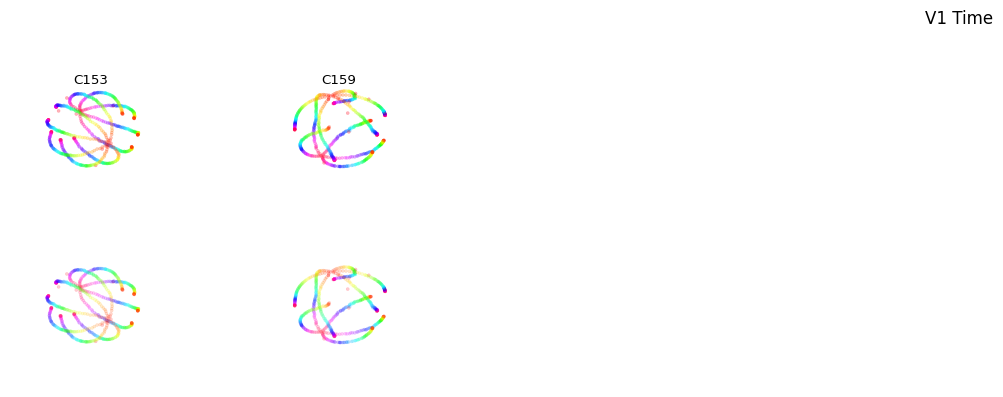

In [26]:
#single_session = pd.read_pickle(r"C:\Users\denmanlab\Desktop\Emily_rotation\luminance_flash\CEBRA\V1_32d_unsup_time_luminance_flash.pkl")
#recordings = ['d4','d5','C155','C159','C160']

fig = plt.figure(figsize=(20,4))

for n, name in enumerate(good_recordings):
    embedding = single_session[name]['embedding']
    # label     = single_session[name]['labels']

    # Use subplot2grid for better control over positioning
    ax = plt.subplot2grid((2, 8), (0, n), projection='3d')
    ax.scatter(embedding[:,0],
               embedding[:,1],
               embedding[:,2],
               s=5, alpha=0.3,
               cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True
               )
    ax.set_title(name, y=0.8)
    
    ax = plt.subplot2grid((2, 8), (1, n), projection='3d')
    ax.scatter(embedding[:,0],
               embedding[:,1],
               embedding[:,2],
               s=5, alpha=0.2,
               cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True
               )

for axs in fig.get_axes():
    axs.axis('off')
    axs.grid(False)
    axs.xaxis.pane.fill = False
    axs.yaxis.pane.fill = False
    axs.zaxis.pane.fill = False
    axs.xaxis.pane.set_edgecolor('w')
    axs.yaxis.pane.set_edgecolor('w')
    axs.zaxis.pane.set_edgecolor('w')

plt.subplots_adjust(wspace=0,
                    hspace=0)
plt.suptitle('V1 Time')
plt.tight_layout()
# plt.savefig(r'G:\cebra_v1_time.pdf',transparent=True)
plt.show()

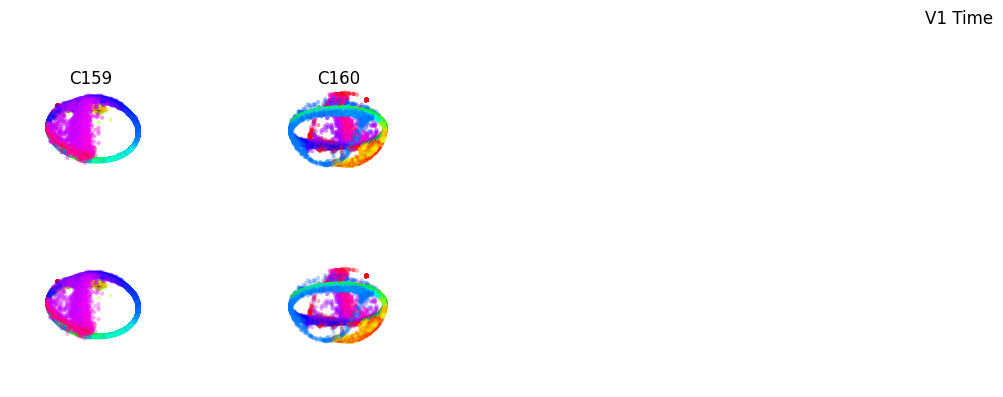

In [44]:
single_session = pd.read_pickle(r"C:\Users\denmanlab\Desktop\Emily_rotation\drifting_gratings\CEBRA\V1_3d_unsup_time_drifting_gratings.pkl")
recordings = ['C159','C160']

fig = plt.figure(figsize=(20,4))

for n, name in enumerate(recordings):
    embedding = single_session[name]['embedding']
    # label     = single_session[name]['labels']

    # Use subplot2grid for better control over positioning
    ax = plt.subplot2grid((2, 8), (0, n), projection='3d')
    ax.scatter(embedding[:,0],
               embedding[:,1],
               embedding[:,2],
               s=5, alpha=0.3,
               cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True
               )
    ax.set_title(name, y=0.8)
    
    ax = plt.subplot2grid((2, 8), (1, n), projection='3d')
    ax.scatter(embedding[:,0],
               embedding[:,1],
               embedding[:,2],
               s=5, alpha=0.2,
               cmap='hsv', c=np.linspace(0,1,len(embedding)), clim=(0,1), rasterized=True
               )

for axs in fig.get_axes():
    axs.axis('off')
    axs.grid(False)
    axs.xaxis.pane.fill = False
    axs.yaxis.pane.fill = False
    axs.zaxis.pane.fill = False
    axs.xaxis.pane.set_edgecolor('w')
    axs.yaxis.pane.set_edgecolor('w')
    axs.zaxis.pane.set_edgecolor('w')

plt.subplots_adjust(wspace=0,
                    hspace=0)
plt.suptitle('V1 Time')
plt.tight_layout()
# plt.savefig(r'G:\cebra_v1_time.pdf',transparent=True)
plt.show()